In [1]:
import tensorflow as tf
print(tf.__version__)

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

import tensorflow_hub as hub

import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

import io
import os
import datetime
import json
import time

import gc
import sys
from types import ModuleType, FunctionType
from gc import get_referents

2.3.0


In [2]:
%load_ext tensorboard

# GPU check

In [10]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num CPUs Available: ", len(tf.config.experimental.list_physical_devices('CPU')))

Num GPUs Available:  1
Num CPUs Available:  1


In [11]:
tf.debugging.set_log_device_placement(False)

In [12]:
size=15**3
m_n = np.random.random((size,size))

In [13]:
cpu_times = []
with tf.device('/CPU:0'):
    m_tf = tf.constant(m_n)
    for i in range(10):
        start = time.time()
        result = tf.matmul(m_tf, m_tf)
        end = time.time()

    exec_time = end-start
    cpu_times.append(exec_time)

cpu_time_mean = np.mean(cpu_times)
cpu_time_std = np.std(cpu_times)

print(f"CPU: mean={cpu_time_mean}, std={cpu_time_std}")

CPU: mean=0.53908371925354, std=0.0


In [14]:
gpu_times = []
with tf.device('/GPU:0'):
    m_tf = tf.constant(m_n)
    for i in range(10):
        start = time.time()
        result = tf.matmul(m_tf, m_tf)
        end = time.time()
    
    exec_time = end-start
    gpu_times.append(exec_time)

gpu_time_mean = np.mean(gpu_times)
gpu_time_std = np.std(gpu_times)

print(f"GPU: mean={gpu_time_mean}, std={gpu_time_std}")

GPU: mean=4.315376281738281e-05, std=0.0


In [15]:
numpy_times = []
for i in range(10):

    start = time.time()
    result = np.matmul(m_n, m_n)
    end = time.time()
    
    exec_time = end-start
    numpy_times.append(exec_time)

numpy_time_mean = np.mean(numpy_times)
numpy_time_std = np.std(numpy_times)

print(f"NumPy: mean={numpy_time_mean}, std={numpy_time_std}")

NumPy: mean=0.3982331991195679, std=0.0644165405084919


In [16]:
speedup = cpu_time_mean/gpu_time_mean
print(f"Tensorflow GPU to Tensorflow CPU speedup: x{speedup:.0f}") 

Tensorflow GPU to Tensorflow CPU speedup: x12492


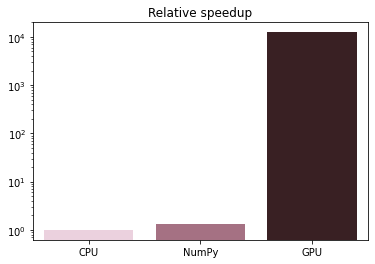

In [17]:
cpu_speedup = 1
numpy_speedup = cpu_time_mean/numpy_time_mean
gpu_speedup = cpu_time_mean/gpu_time_mean

data = {'speedups':[cpu_speedup, numpy_speedup, gpu_speedup],
       'method':['CPU', 'NumPy', 'GPU']}

ax = sns.barplot(x='method', y='speedups', data=data, palette=sns.cubehelix_palette(3, start=.9, rot=-.10))

ax.set_title("Relative speedup")

ax.set_yscale('log')

In [18]:
del m_n
del m_tf
del result

In [19]:
gc.collect()

3390

# Load dataset

## Dataset with subwords

In [20]:
imdb_dataset, info = tfds.load('imdb_reviews/subwords8k',
                         split=['train', 'test[:50%]', 'test[50%:]'],
                         as_supervised=True,
                         with_info=True)

In [21]:
print(imdb_dataset)

[<PrefetchDataset shapes: ((None,), ()), types: (tf.int64, tf.int64)>, <PrefetchDataset shapes: ((None,), ()), types: (tf.int64, tf.int64)>, <PrefetchDataset shapes: ((None,), ()), types: (tf.int64, tf.int64)>]


In [30]:
train_dataset = imdb_dataset[0]
valid_dataset = imdb_dataset[1]
test_dataset = imdb_dataset[2]

In [23]:
info

tfds.core.DatasetInfo(
    name='imdb_reviews',
    version=1.0.0,
    description='Large Movie Review Dataset.
This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.',
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
        'text': Text(shape=(None,), dtype=tf.int64, encoder=<SubwordTextEncoder vocab_size=8185>),
    }),
    total_num_examples=100000,
    splits={
        'test': 25000,
        'train': 25000,
        'unsupervised': 50000,
    },
    supervised_keys=('text', 'label'),
    citation="""@InProceedings{maas-EtAl:2011:ACL-HLT2011,
      author    = {Maas, Andrew L.  and  Daly, Raymond E.  and  Pham, Peter T.  and  Huang, Dan  and  Ng, Andrew Y.  and  Pot

In [28]:
encoder = info.features['text'].encoder

## Raw dataset

In [21]:
imdb_dataset = tfds.load('imdb_reviews', split=['train', 'test[:50%]', 'test[50%:]'], as_supervised=True)

In [76]:
train_ds = imdb_dataset[0]
val_ds = imdb_dataset[1]
test_ds = imdb_dataset[2]

In [ ]:
imdb_dataset.features

In [77]:
TRAIN_DS_SIZE = train_ds.cardinality().numpy()
VAL_DS_SIZE = val_ds.cardinality().numpy()
TEST_DS_SIZE = test_ds.cardinality().numpy()

print(f"train_ds size: {TRAIN_DS_SIZE}")
print(f"val_ds size: {VAL_DS_SIZE}")
print(f"test_ds size: {TEST_DS_SIZE}")

train_ds size: 25000
val_ds size: 12500
test_ds size: 12500


# Tokenization and encoding

## First approach: Keras Tokenizer

In [25]:
def dataset_to_texts_and_labels(ds):
    ds_length = ds.cardinality().numpy()
    
    # Convert from tf.data.Dataset to list
    ds = next(ds.batch(ds_length).as_numpy_iterator())
    
    # Get lists
    texts, labels = list(ds[0]), list(ds[1])
    
    # Convert from b string to utf-8 string
    texts = list(map(lambda b_string: b_string.decode('utf-8'), texts))
    
    return texts, labels

In [26]:
%time train_texts, train_y = dataset_to_texts_and_labels(train_ds)
%time valid_texts, valid_y = dataset_to_texts_and_labels(val_ds)
%time test_texts, test_y = dataset_to_texts_and_labels(test_ds)

all_texts = train_texts + valid_texts + test_texts

CPU times: user 1.86 s, sys: 686 ms, total: 2.55 s
Wall time: 1.68 s
CPU times: user 847 ms, sys: 298 ms, total: 1.15 s
Wall time: 386 ms
CPU times: user 787 ms, sys: 356 ms, total: 1.14 s
Wall time: 334 ms


In [27]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token='<oov>')
%time tokenizer.fit_on_texts(all_texts)

CPU times: user 7.19 s, sys: 14.6 ms, total: 7.21 s
Wall time: 7.21 s


In [28]:
%time train_x = tokenizer.texts_to_sequences(train_texts)
%time valid_x = tokenizer.texts_to_sequences(valid_texts)
%time test_x = tokenizer.texts_to_sequences(test_texts)

CPU times: user 2.26 s, sys: 21.4 ms, total: 2.28 s
Wall time: 2.28 s
CPU times: user 1.11 s, sys: 2.57 ms, total: 1.11 s
Wall time: 1.11 s
CPU times: user 1.11 s, sys: 14.5 ms, total: 1.12 s
Wall time: 1.12 s


In [61]:
train_dataset = tf.data.Dataset.from_generator(lambda: iter(zip(train_x, train_y)),
                                               output_types=(tf.int32, tf.int32),
                                               output_shapes=(tf.TensorShape([None]), tf.TensorShape([]))).take(TRAIN_DS_SIZE)

valid_dataset = tf.data.Dataset.from_generator(lambda: iter(zip(valid_x, valid_y)),
                                               output_types=(tf.int32, tf.int32),
                                               output_shapes=(tf.TensorShape([None]), tf.TensorShape([]))).take(VAL_DS_SIZE)

test_dataset = tf.data.Dataset.from_generator(lambda: iter(zip(test_x, test_y)),
                                              output_types=(tf.int32, tf.int32),
                                              output_shapes=(tf.TensorShape([None]), tf.TensorShape([]))).take(TEST_DS_SIZE)

In [30]:
next(iter(train_dataset))

(<tf.Tensor: shape=(163,), dtype=int64, numpy=
 array([  62,   18,   41,  604,  927,   65,    3,  644, 7968,   21,   35,
        5096,   36,   11,   43, 2948, 5240,  102,   50,  681, 7862, 1244,
           3, 3266,   29,  122,  640,    2,   26,   14,  279,  438,   35,
          79,  349,  384,   11, 1991,    3,  492,   79,  122,  188,  117,
          33, 4047, 4531,   14,   65, 7968,    8, 1819, 3947,    3,   62,
          27,    9,   41,  577, 5044, 2629, 2552, 7193, 7961, 3642,    3,
          19,  107, 3903,  225,   85,  198,   72,    1, 1512,  738, 2347,
         102, 6245,    8,   85,  308,   79, 6936, 7961,   23, 4981, 8044,
           3, 6429, 7961, 1141, 1335, 1848, 4848,   55, 3601, 4217, 8050,
           2,    5,   59, 3831, 1484, 8040, 7974,  174, 5773,   22, 5240,
         102,   18,  247,   26,    4, 3903, 1612, 3902,  291,   11,    4,
          27,   13,   18, 4092, 4008, 7961,    6,  119,  213, 2774,    3,
          12,  258, 2306,   13,   91,   29,  171,   52,  229,    

## Second approach: tfds Tokenizer and Encoder

In [14]:
# %%time
# tokenizer = tfds.features.text.Tokenizer()
# vocabulary = set()
# for dataset in [train_ds, val_ds, test_ds]:
#     for batch in dataset:
#         for x,y in batch:
#             vocabulary.update(tokenizer.tokenize(x.numpy()))

In [15]:
# len(vocabulary)

In [16]:
# encoder = tfds.features.text.TokenTextEncoder(vocabulary)
# def encode(x, y):
#     x = encoder.encode(x.numpy())
#     return x, y

# def encode_map_fn(x, y):
#     x, y = tf.py_function(encode,
#                          inp=[x, y],
#                          Tout=(tf.int64, tf.int64))
#     x.set_shape([None])
#     y.set_shape([])
#     return x, y

In [17]:
# %time train_dataset = train_ds.map(encode_map_fn)
# %time valid_dataset = val_ds.map(encode_map_fn)
# %time test_dataset = test_ds.map(encode_map_fn)

In [30]:
next(iter(train_dataset))

Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op IteratorGetNext in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0


(<tf.Tensor: shape=(117,), dtype=int32, numpy=
 array([   12,    14,    33,   420,   382,    18,    90,    27, 11312,
            9,    32,  1460,  4087,    39,   499, 10040,   196,    24,
           79,   151,    19,    12,   207,   331,    27,    66,   247,
          215,     9,   485,    58,    66,    79,   114,    99,    22,
         5800,    12,  1381,   647,   774,    12,    18,     7,    33,
          405,  9016,   177,  2328,   413,     2,    89,  1152,   135,
           71,   144,    51,     2, 35686,  6553,    71,   233,    66,
         3097,    16, 20563,  3150, 24417, 22710,  1531,  4680,     3,
           41,  3805,   113,  1505,    17,  4087,    14,   162,    19,
            4,  1152,   888,  9017,     9,     4,    18,    13,    14,
         3855,     5,   100,   145,  1159,    11,   236,   681,    13,
           47,    24,    98,    38,    12,  8162,  5238,    38,  1460,
        16388,    50,   390,    11,    99,  1184,   847,   141,    10],
       dtype=int32)>,
 <tf.Te

# Dataset optimization

In [31]:
SEQUENCE_LEN = 300

def pad_or_truncate(x, y):
    length = SEQUENCE_LEN
    x = x[:length]
    if x.shape[0] < length:
        x = tf.concat([x, tf.zeros(length-x.shape[0], dtype=tf.int32)], axis=0)
    return x, y

def pad_or_truncate_map_fn(x, y):
    x, y = tf.py_function(pad_or_truncate, inp=[x, y], Tout=(tf.int32, tf.int32))
    x.set_shape([SEQUENCE_LEN])
    y.set_shape([])
    return x, y

In [32]:
BATCH_SIZE = 64
train_dataset = train_dataset.cache().shuffle(1024).padded_batch(batch_size=BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
valid_dataset = valid_dataset.cache().padded_batch(batch_size=BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.cache().padded_batch(batch_size=BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

# BATCH_SIZE = 32
# train_dataset = train_dataset.cache().shuffle(1024).map(pad_or_truncate_map_fn).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
# valid_dataset = valid_dataset.cache().map(pad_or_truncate_map_fn).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
# test_dataset = test_dataset.cache().map(pad_or_truncate_map_fn).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

# BATCH_SIZE = 32
# train_dataset = train_dataset.shuffle(1024).map(pad_or_truncate_map_fn).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
# valid_dataset = valid_dataset.map(pad_or_truncate_map_fn).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
# test_dataset = test_dataset.map(pad_or_truncate_map_fn).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

# Prepare embedding layer

## Obtain word vectors

In [21]:
# !wget -O embeddings.zip http://vectors.nlpl.eu/repository/20/8.zip

In [22]:
# !unzip embeddings.zip
# !rm embeddings.zip
# !rm model.bin
# !rm README

In [15]:
# with open('meta.json') as f:
#     data = json.load(f)

# data

In [16]:
path = os.path.join(os.getcwd(), 'model.txt')

In [17]:
def load_vectors(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    for line in fin:
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = list(map(float, tokens[1:]))
    return data

In [18]:
%time word_vectors = load_vectors(path)

CPU times: user 18.2 s, sys: 1.48 s, total: 19.6 s
Wall time: 20.2 s


# create embedding matrix

## Keras tokenizer compatible approach

In [33]:
def keras_tokenizer_embedding_matrix(tokenizer, word_vectors):
    n = len(tokenizer.index_word)+1
    d = len(list(word_vectors.values())[0])
    embedding_matrix = np.zeros((n,d))
    for i, word in tokenizer.index_word.items():
        vector = word_vectors.get(word, np.zeros(d))
        embedding_matrix[i] = vector
    return embedding_matrix

In [34]:
%time embedding_matrix = keras_tokenizer_embedding_matrix(tokenizer, word_vectors)

CPU times: user 755 ms, sys: 64.1 ms, total: 819 ms
Wall time: 817 ms


In [35]:
embedding_matrix.shape

(124254, 300)

In [125]:


# Custom objects know their class.
# Function objects seem to know way too much, including modules.
# Exclude modules as well.
BLACKLIST = type, ModuleType, FunctionType


def getsize(obj):
    """sum size of object & members."""
    if isinstance(obj, BLACKLIST):
        raise TypeError('getsize() does not take argument of type: '+ str(type(obj)))
    seen_ids = set()
    size = 0
    objects = [obj]
    while objects:
        need_referents = []
        for obj in objects:
            if not isinstance(obj, BLACKLIST) and id(obj) not in seen_ids:
                seen_ids.add(id(obj))
                size += sys.getsizeof(obj)
                need_referents.append(obj)
        objects = get_referents(*need_referents)
    return size/1024**2

In [ ]:
# word_vec_size = getsize(word_vectors)
# emb_m_size = getsize(embedding_matrix)
# print(f"word_vectors size: {word_vec_size:10.0}")

In [36]:
# To free memory
del word_vectors

## tfds tokenizer and encoder compatible approach

In [30]:
# def tfds_embedding_matrix(vocabulary, encoder, word_vectors):
#     n = len(list(word_vectors.keys()))
#     d = len(list(word_vectors.values())[0])
#     embedding_matrix = np.zeros((n,d))
#     for word in vocabulary:
#         i = encoder.encode(word)[0]
#         vector = word_vectors.get(word, np.zeros(d))
#         embedding_matrix[i] = vector
#     return embedding_matrix

In [31]:
# %time embedding_matrix = tfds_embedding_matrix(vocabulary, encoder, word_vectors)

# Model architecture

In [26]:
next(iter(train_dataset))

(<tf.Tensor: shape=(32, 850), dtype=int64, numpy=
 array([[  69,   18, 1010, ...,    0,    0,    0],
        [  62,   27,  579, ...,    0,    0,    0],
        [2509, 4422, 7961, ...,    0,    0,    0],
        ...,
        [ 592, 3192,  792, ...,    0,    0,    0],
        [  12,   31,  247, ...,    0,    0,    0],
        [  12,  264,   33, ...,    0,    0,    0]])>,
 <tf.Tensor: shape=(32,), dtype=int64, numpy=
 array([0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 1, 0, 0, 0, 0])>)

In [33]:
do_rate = 0.1 #0
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None,)),
    tf.keras.layers.Embedding(encoder.vocab_size, 128,
#                               embeddings_initializer=tf.keras.initializers.constant(embedding_matrix),
#                               trainable=False
                             ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(do_rate),
#     tf.keras.layers.Dense(512, activation='relu'),
#     tf.keras.layers.Dropout(do_rate),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
#               optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 128)         1047680   
_________________________________________________________________
bidirectional_4 (Bidirection (None, None, 128)         98816     
_________________________________________________________________
bidirectional_5 (Bidirection (None, None, 128)         98816     
_________________________________________________________________
bidirectional_6 (Bidirection (None, None, 128)         98816     
_________________________________________________________________
bidirectional_7 (Bidirection (None, 256)               263168    
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 256)              

# Save embedding layer as model

In [162]:
# embedding_model = tf.keras.Sequential([model.layers[0]])
# embedding_model.compile()

In [163]:
# embedding_model.save(os.path.join(os.getcwd(), "embedding_model"))

# Training

In [34]:
log_dir = os.path.join(os.getcwd(), "logs/fit/")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0, update_freq='epoch')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(os.path.join(os.getcwd(), 'model'),
                                                               save_freq='epoch', save_best_only=True)

In [35]:
log_dir

'/home/jan/ml_own_projects/text_data_projects/imdb_reviews/logs/fit/'

In [36]:
history = model.fit(train_dataset,
                    validation_data=valid_dataset,
                    epochs=10,
                    callbacks=[tensorboard_callback])

Epoch 1/10
  1/391 [..............................] - ETA: 0s - loss: 0.6929 - accuracy: 0.5938WARNING:tensorflow:From /home/jan/.local/lib/python3.7/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.


Instructions for updating:
use `tf.profiler.experimental.stop` instead.


391/391 [==============================] - 173s 442ms/step - loss: 0.5594 - accuracy: 0.6918 - val_loss: 0.4408 - val_accuracy: 0.8046
Epoch 2/10
391/391 [==============================] - 171s 437ms/step - loss: 0.3536 - accuracy: 0.8551 - val_loss: 0.3792 - val_accuracy: 0.8370
Epoch 3/10
391/391 [==============================] - 172s 440ms/step - loss: 0.2642 - accuracy: 0.8986 - val_loss: 0.3573 - val_accuracy: 0.8549
Epoch 4/10
391/391 [==============================] - 169s 432ms/step - loss: 0.2335 - accuracy: 0.9147 - val_loss: 0.3717 - val_accuracy: 0.8582
Epoch 5/10
391/391 [==============================] - 171s 437ms/step - loss: 0.1909 - accuracy: 0.9328 - val_loss: 0.4108 - val_accuracy: 0.8482
Epoch 6/10
391/391 [==============================] - 170s 436ms/step - loss: 0.1749 - accuracy: 0.9389 - val_loss: 0.4383 - val_accuracy: 0.8522
Epoch 7/10
391/391 [==============================] - 170s 435ms/step - loss: 0.1520 - accuracy: 0.9480 - val_loss: 0.4763 - val_accura

In [9]:
%tensorboard --logdir $log_dir